# LeNet

LeNet, developed by Yann LeCun and his team, is one of the earliest convolutional neural networks (CNNs). It was designed for handwritten digit recognition, particularly for tasks like recognizing digits in postal codes and bank checks (e.g., the MNIST dataset).

LeNet-5 is the most well-known and impactful version in the LeNet family. It was the first CNN designed for large-scale digit classification tasks. It introduced a structured combination of convolutional layers, pooling layers, and fully connected layers. LeNet-5 was specifically designed to handle datasets like MNIST effectively, demonstrating that CNNs could scale to larger, practical problems. It set the blueprint for many modern CNN architectures and was fully trainable using gradient-based optimization.

The figure below depicts the architecture:

![LeNet-5 Architecture](LeNet5_architecture.jpeg)

*Figure: LeNet-5 architecture. Source: [Siddhesh Bangar](https://medium.com/@siddheshb008/lenet-5-architecture-explained-3b559cb2d52b).*

The modern adaptation diverges slightly from the original to reflect modern best practices:
 
- __ReLU Activation__: Reduces vanishing gradient issues.
- __Fixed Pooling__: Simplifies training and implementation.
- __Flattened Input Adjustment__: Matches layer dimensions without strict adherence to original design constraints.


## LeNet-5 Architecture

### Input
- **Size:** 32x32 grayscale image (1 channel)

---

### Convolutional Layers
1. **Conv1:**
   - **Input:** (1, 32, 32)
   - **Layer:** Convolutional
   - **Output:** (6, 32, 32)
   - **Filter size:** 5x5
   - **Stride:** 1
   - **Padding:** 2
   - **Activation:** ReLU

2. **Pooling1:**
   - **Input:** (6, 32, 32)
   - **Layer:** Average Pooling
   - **Output:** (6, 16, 16)
   - **Filter size:** 2x2
   - **Stride:** 2

3. **Conv2:**
   - **Input:** (6, 16, 16)
   - **Layer:** Convolutional
   - **Output:** (16, 12, 12)
   - **Filter size:** 5x5
   - **Stride:** 1
   - **Padding:** 0
   - **Activation:** ReLU

4. **Pooling2:**
   - **Input:** (16, 12, 12)
   - **Layer:** Average Pooling
   - **Output:** (16, 6, 6)
   - **Filter size:** 2x2
   - **Stride:** 2

---

### Fully Connected Layers
1. **FC1:**
   - **Input:** Flattened (16 * 6 * 6 = 576)
   - **Layer:** Fully Connected
   - **Output:** 120
   - **Activation:** ReLU

2. **FC2:**
   - **Input:** 120
   - **Layer:** Fully Connected
   - **Output:** 84
   - **Activation:** ReLU

3. **FC3 (Output Layer):**
   - **Input:** 84
   - **Layer:** Fully Connected
   - **Output:** 10 (number of classes)
   - **Activation:** None (logits)

---

### Summary
- **Total Parameters:**
  - Convolutional Layers: Learnable filters
  - Fully Connected Layers: Dense connections
- **Designed for:** Digit classification (e.g., MNIST dataset)
- **Pooling Method:** Average Pooling (used instead of Max Pooling, as per the original paper)
- **Significance:** Laid the foundation for modern CNN architectures.

## Imports

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import platform
from tqdm import tqdm

### Check and Setup CUDA

In [15]:
if platform.system() == "Darwin" and platform.machine().startswith("arm"):
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
else:
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(DEVICE)

cuda


### Config

In [16]:
EPOCHS = 100
BATCH_SIZE = 32
LEARNING_RATE = 0.001

In [17]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

In [18]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False)

classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [19]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


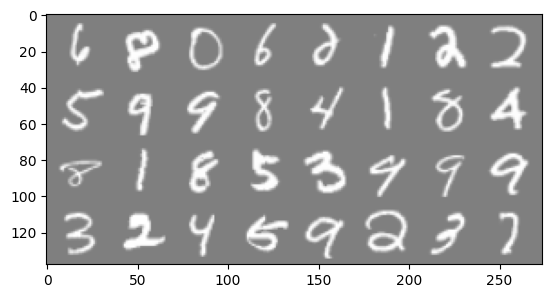

In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))


### CNN Model

In [21]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, 5, 1, 2),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(6, 16, 5, 1, 0),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(16 * 6 * 6, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

In [22]:
model = LeNet5().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

n_total_steps = len(train_loader)

In [23]:
for epoch in tqdm(range(EPOCHS)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

100%|██████████| 100/100 [15:22<00:00,  9.23s/it]


In [24]:
print('Finished Training')
PATH = './LeNet5.pth'
torch.save(model.state_dict(), PATH)


Finished Training


In [25]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(10):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Accuracy of the network: 99.23 %
Accuracy of 0: 98.99328859060402 %
Accuracy of 1: 99.44289693593315 %
Accuracy of 2: 99.44289693593315 %
Accuracy of 3: 99.05660377358491 %
Accuracy of 4: 100.0 %
Accuracy of 5: 97.6 %
Accuracy of 6: 98.93617021276596 %
Accuracy of 7: 99.67637540453075 %
Accuracy of 8: 99.3006993006993 %
Accuracy of 9: 99.69788519637463 %
